# Gesture Recognition

In this project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import imageio
from skimage.transform import resize, rescale
import datetime
import os

import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
#%tensorflow_version 1.x

In [3]:
import tensorflow as tf
print(tf.__version__)
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
tf.set_random_seed(30)

1.10.0


Using TensorFlow backend.


In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
#from zipfile import ZipFile
#with ZipFile('/content/drive/My Drive/Colab Notebooks/Project_data.zip','r') as zip:
#    zip.extractall()

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/val.csv').readlines())
num_classes = 5  #number of softmax classes

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = '/mnt/disks/user/project/PROJECT/Project_data/train'
val_path = '/mnt/disks/user/project/PROJECT/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Common Utils

Common utility to plot loss and accuracy

In [8]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Common utility to calculate steps

In [9]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

Common utility for callbacks

In [10]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]    

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image.py:787: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


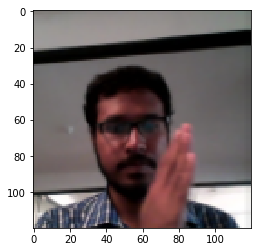

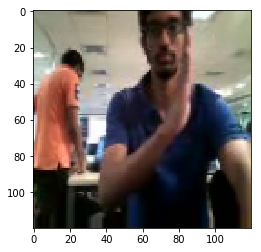

In [11]:
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import smart_resize

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

## Test code start
#360 by 360
image1 = imageio.imread("/mnt/disks/user/project/PROJECT/Project_data/val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00029.png")
#160 by 120
image2 = imageio.imread("/mnt/disks/user/project/PROJECT/Project_data/val/WIN_20180926_17_56_52_Pro_Right_Swipe_new/WIN_20180926_17_56_52_Pro_00029.png")
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes                    
#print(image1.shape, image2.shape)
image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)                   
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)                 
plt.imshow(image2)
plt.show()
## Test code end

def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        #img_idx = sorted(rn.sample(range(0, total_frames), num_images)) #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    #batch_data[folder,idx,:,:,0] = (image[...,0] - image[...,0].min())/(image[...,0].max() - image[...,0].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] = (image[...,1] - image[...,1].min())/(image[...,1].max() - image[...,1].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] = (image[...,2] - image[...,2].min())/(image[...,2].max() - image[...,2].min())#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

### Conv3d Models

In [13]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

#### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)


In [14]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalizat

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [16]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 294s 4s/step - loss: 1.5978 - categorical_accuracy: 0.4528 - val_loss: 1.3501 - val_categorical_accuracy: 0.5500

Epoch 00001: val_loss improved from inf to 1.35014, saving model to model_conv3D_1_2020-08-1707_24_06.087739/model-00001-1.58374-0.45400-1.35014-0.55000.h5
Epoch 2/25
67/67 [==============================] - 180s 3s/step - loss: 1.1176 - categorical_accuracy: 0.5801 - val_loss: 1.4703 - val_categorical_accuracy: 0.4300

Epoch 00002: val_loss did not improve from 1.35014
Epoch 3/25
67/67 [==============================] - 193s 3s/step - loss: 0.9549 - categorical_accuracy: 0.6523 - val_loss: 1.3649 - val_categorical_accuracy: 0.5200

Epoch 00003: val_loss did not improve from 1.35014
Epoch 4/25
67/67 [==============================] - 169s 3s/step - loss: 1.2015 - categorical_accuracy: 0.5428 - val_loss: 1.4754 - val_categorical_accuracy: 0.5100

Epoch 00004: val_loss did not improve from 1.35014
Epoch 5/25
67/67 [====================

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


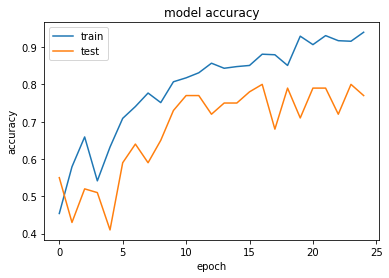

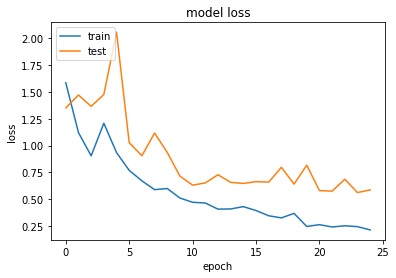

In [17]:
plot_loss_accuracy(history)

#### Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [27]:
num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# batch size = 10
# num_frames per video = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_22 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_23 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_20 (Batc (

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [28]:
callbacks_list = model_callbacks("model_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [29]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 115s 2s/step - loss: 1.5519 - categorical_accuracy: 0.4254 - val_loss: 1.4660 - val_categorical_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 1.46601, saving model to model_conv3D_2_2020-08-1711_05_19.792011/model-00001-1.54317-0.42986-1.46601-0.50000.h5
Epoch 2/20
67/67 [==============================] - 109s 2s/step - loss: 1.2001 - categorical_accuracy: 0.5498 - val_loss: 1.6210 - val_categorical_accuracy: 0.5800

Epoch 00002: val_loss did not improve from 1.46601
Epoch 3/20
67/67 [==============================] - 112s 2s/step - loss: 0.9810 - categorical_accuracy: 0.6299 - val_loss: 2.6316 - val_categorical_accuracy: 0.4200

Epoch 00003: val_loss did not improve from 1.46601
Epoch 4/20
67/67 [==============================] - 113s 2s/step - loss: 0.8953 - categorical_accuracy: 0.6807 - val_loss: 2.2908 - val_categorical_accuracy: 0.3700

Epoch 00004: val_loss did not improve from 1.46601
Epoch 5/20
67/67 [====================

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


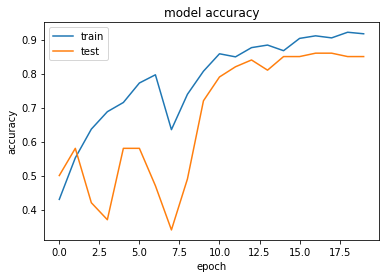

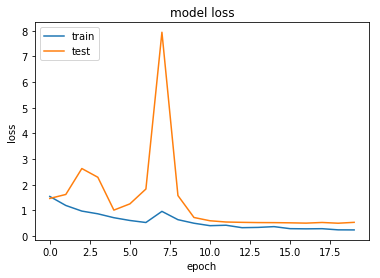

In [30]:
plot_loss_accuracy(history)

#### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160)

In [15]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 80, 80, 32)    13856     
_________________________________________________________________
activation_9 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalizat

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
callbacks_list = model_callbacks("model_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

In [17]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 335s 5s/step - loss: 1.6470 - categorical_accuracy: 0.4278 - val_loss: 4.2629 - val_categorical_accuracy: 0.4200

Epoch 00001: val_loss improved from inf to 4.26289, saving model to model_conv3D_3_2020-08-1714_02_41.746177/model-00001-1.64309-0.42534-4.26289-0.42000.h5
Epoch 2/20
67/67 [==============================] - 189s 3s/step - loss: 1.1694 - categorical_accuracy: 0.5566 - val_loss: 1.3488 - val_categorical_accuracy: 0.5200

Epoch 00002: val_loss improved from 4.26289 to 1.34875, saving model to model_conv3D_3_2020-08-1714_02_41.746177/model-00002-1.17562-0.55204-1.34875-0.52000.h5
Epoch 3/20
67/67 [==============================] - 212s 3s/step - loss: 1.1360 - categorical_accuracy: 0.5587 - val_loss: 1.7929 - val_categorical_accuracy: 0.4200

Epoch 00003: val_loss did not improve from 1.34875
Epoch 4/20
67/67 [==============================] - 206s 3s/step - loss: 0.9383 - categorical_accuracy: 0.6383 - val_loss: 1.3829 - val_categorica

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


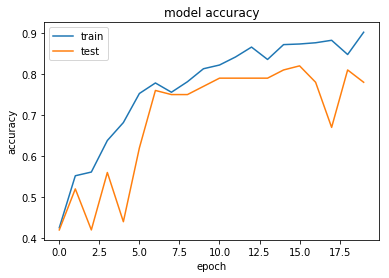

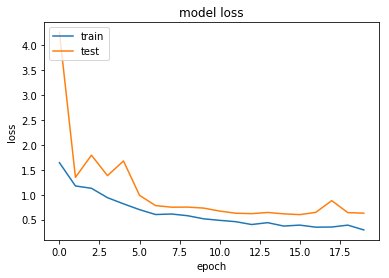

In [18]:
plot_loss_accuracy(history)

#### Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160)

In [18]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_9 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalizat

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [19]:
callbacks_list = model_callbacks("model_conv3D_4")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

In [20]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 263s 4s/step - loss: 1.5327 - categorical_accuracy: 0.4766 - val_loss: 2.4515 - val_categorical_accuracy: 0.3300

Epoch 00001: val_loss improved from inf to 2.45151, saving model to model_conv3D_4_2020-08-1711_05_19.792011/model-00001-1.51836-0.47813-2.45151-0.33000.h5
Epoch 2/20
67/67 [==============================] - 130s 2s/step - loss: 1.1179 - categorical_accuracy: 0.5741 - val_loss: 1.6836 - val_categorical_accuracy: 0.5000

Epoch 00002: val_loss improved from 2.45151 to 1.68361, saving model to model_conv3D_4_2020-08-1711_05_19.792011/model-00002-1.12307-0.57315-1.68361-0.50000.h5
Epoch 3/20
67/67 [==============================] - 121s 2s/step - loss: 0.9518 - categorical_accuracy: 0.6299 - val_loss: 2.1900 - val_categorical_accuracy: 0.3700

Epoch 00003: val_loss did not improve from 1.68361
Epoch 4/20
67/67 [==============================] - 140s 2s/step - loss: 1.0504 - categorical_accuracy: 0.6140 - val_loss: 10.5907 - val_categoric

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


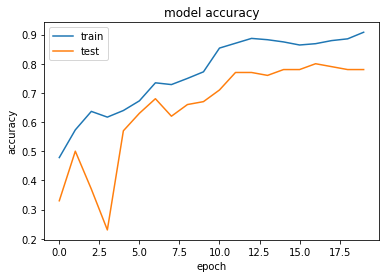

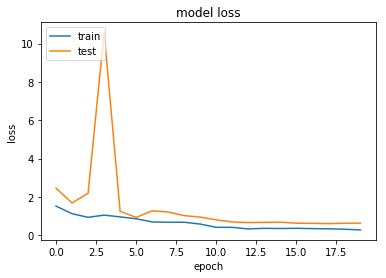

In [21]:
plot_loss_accuracy(history)

#### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer) + Random data transformations on training data set

In [19]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_15 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_16 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalizat

In [20]:
callbacks_list = model_callbacks("model_conv3D_5")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [21]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 195s 3s/step - loss: 1.7452 - categorical_accuracy: 0.3792 - val_loss: 2.6609 - val_categorical_accuracy: 0.3500

Epoch 00001: val_loss improved from inf to 2.66091, saving model to model_conv3D_5_2020-08-1714_02_41.746177/model-00001-1.73287-0.38311-2.66091-0.35000.h5
Epoch 2/15
67/67 [==============================] - 205s 3s/step - loss: 1.4684 - categorical_accuracy: 0.4428 - val_loss: 3.1332 - val_categorical_accuracy: 0.3300

Epoch 00002: val_loss did not improve from 2.66091
Epoch 3/15
67/67 [==============================] - 204s 3s/step - loss: 1.3028 - categorical_accuracy: 0.4931 - val_loss: 1.7819 - val_categorical_accuracy: 0.4600

Epoch 00003: val_loss improved from 2.66091 to 1.78193, saving model to model_conv3D_5_2020-08-1714_02_41.746177/model-00003-1.29350-0.49472-1.78193-0.46000.h5
Epoch 4/15
67/67 [==============================] - 206s 3s/step - loss: 1.4906 - categorical_accuracy: 0.4314 - val_loss: 1.5359 - val_categorica

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


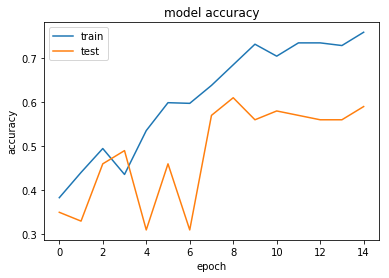

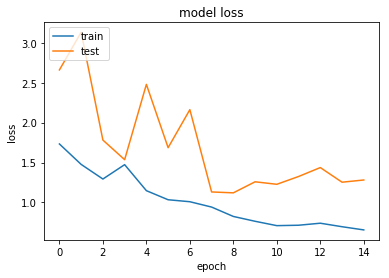

In [22]:
plot_loss_accuracy(history)

#### Conv 3D Model with 30 frames per video (8, 16, 32, 64 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [18]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (8, 16, 32, 64) 
model = conv3D(conv_filters, num_images=num_frames)
print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_8 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
activation_9 (Activation)    (None, 15, 60, 60, 16)    0         
_________________________________________________________________
batch_normalizat

In [19]:
callbacks_list = model_callbacks("model_conv3D_6")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [20]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 184s 3s/step - loss: 1.5707 - categorical_accuracy: 0.4144 - val_loss: 1.3337 - val_categorical_accuracy: 0.5400

Epoch 00001: val_loss improved from inf to 1.33371, saving model to model_conv3D_6_2020-08-1707_24_06.087739/model-00001-1.56926-0.41176-1.33371-0.54000.h5
Epoch 2/25
67/67 [==============================] - 181s 3s/step - loss: 1.2213 - categorical_accuracy: 0.5378 - val_loss: 1.2113 - val_categorical_accuracy: 0.5800

Epoch 00002: val_loss improved from 1.33371 to 1.21127, saving model to model_conv3D_6_2020-08-1707_24_06.087739/model-00002-1.22586-0.53997-1.21127-0.58000.h5
Epoch 3/25
67/67 [==============================] - 163s 2s/step - loss: 1.0145 - categorical_accuracy: 0.5940 - val_loss: 1.0913 - val_categorical_accuracy: 0.5600

Epoch 00003: val_loss improved from 1.21127 to 1.09129, saving model to model_conv3D_6_2020-08-1707_24_06.087739/model-00003-1.01972-0.58974-1.09129-0.56000.h5
Epoch 4/25
67/67 [===================

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


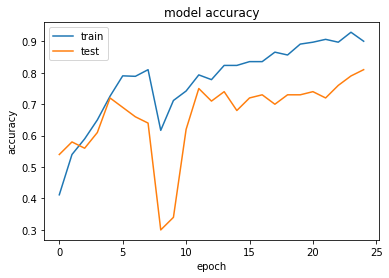

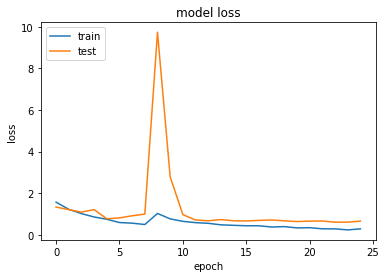

In [21]:
plot_loss_accuracy(history)

#### Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 128 dense layer + 64 dense layer + image size 120 by 120)

In [23]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (16, 32, 64, 128)
dense_filters = (128, 64) 
model = conv3D(conv_filters=conv_filters, dense_nodes=dense_filters, dropout=0.2, num_images=num_frames)
print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_22 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_23 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalizat

In [24]:
callbacks_list = model_callbacks("model_conv3D_7")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=False, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [25]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 173s 3s/step - loss: 1.4799 - categorical_accuracy: 0.4374 - val_loss: 2.0667 - val_categorical_accuracy: 0.4100

Epoch 00001: val_loss improved from inf to 2.06668, saving model to model_conv3D_7_2020-08-1714_02_41.746177/model-00001-1.47298-0.44193-2.06668-0.41000.h5
Epoch 2/25
67/67 [==============================] - 165s 2s/step - loss: 1.1086 - categorical_accuracy: 0.5558 - val_loss: 2.4724 - val_categorical_accuracy: 0.3500

Epoch 00002: val_loss did not improve from 2.06668
Epoch 3/25
67/67 [==============================] - 192s 3s/step - loss: 1.1654 - categorical_accuracy: 0.5626 - val_loss: 0.8944 - val_categorical_accuracy: 0.6400

Epoch 00003: val_loss improved from 2.06668 to 0.89441, saving model to model_conv3D_7_2020-08-1714_02_41.746177/model-00003-1.17178-0.55807-0.89441-0.64000.h5
Epoch 4/25
67/67 [==============================] - 162s 2s/step - loss: 0.9456 - categorical_accuracy: 0.6438 - val_loss: 0.8903 - val_categorica

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


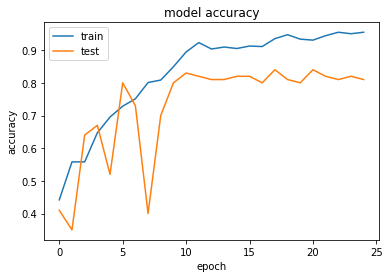

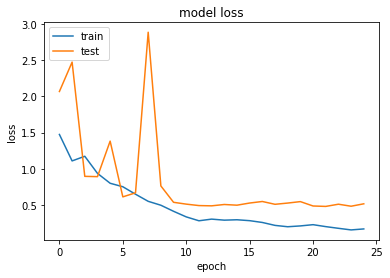

In [26]:
plot_loss_accuracy(history)

#### Conv 3D Model with 20 frames per video (32, 64, 128, 256) filters conv 3D layers + 128 dense layer + 128 dense layer + image size 120 by 120)

In [22]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (32, 64, 128, 256)
dense_filters = (128, 128)
model = conv3D(conv_filters=conv_filters,dense_nodes=dense_filters, num_images=num_frames)
print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 20, 120, 120, 32)  2624      
_________________________________________________________________
activation_15 (Activation)   (None, 20, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 20, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 10, 60, 60, 32)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 10, 60, 60, 64)    55360     
_________________________________________________________________
activation_16 (Activation)   (None, 10, 60, 60, 64)    0         
_________________________________________________________________
batch_normalizat

In [23]:
callbacks_list = model_callbacks("model_conv3D_8")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=False, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [24]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 122s 2s/step - loss: 1.6405 - categorical_accuracy: 0.4104 - val_loss: 1.9979 - val_categorical_accuracy: 0.3300

Epoch 00001: val_loss improved from inf to 1.99790, saving model to model_conv3D_8_2020-08-1707_24_06.087739/model-00001-1.65303-0.40422-1.99790-0.33000.h5
Epoch 2/25
67/67 [==============================] - 118s 2s/step - loss: 1.3198 - categorical_accuracy: 0.4771 - val_loss: 1.0652 - val_categorical_accuracy: 0.5600

Epoch 00002: val_loss improved from 1.99790 to 1.06517, saving model to model_conv3D_8_2020-08-1707_24_06.087739/model-00002-1.32816-0.47511-1.06517-0.56000.h5
Epoch 3/25
67/67 [==============================] - 116s 2s/step - loss: 1.0839 - categorical_accuracy: 0.5737 - val_loss: 1.4138 - val_categorical_accuracy: 0.4500

Epoch 00003: val_loss did not improve from 1.06517
Epoch 4/25
67/67 [==============================] - 116s 2s/step - loss: 0.9823 - categorical_accuracy: 0.6404 - val_loss: 5.2963 - val_categorica

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


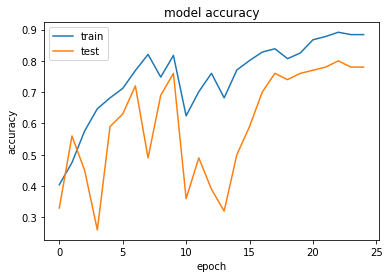

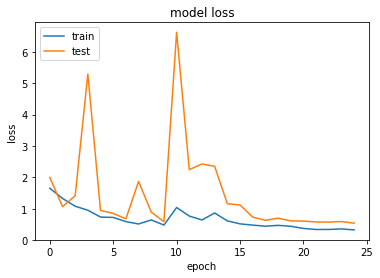

In [25]:
plot_loss_accuracy(history)

#### Conv 3D Model with 30 frames per video and a 5 by 5 filter size (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [22]:
#write your model here
def conv3D_5by5(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (5, 5, 5), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

In [23]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D_5by5(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 120, 120, 16)  6016      
_________________________________________________________________
activation_15 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_16 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalizat

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [24]:
callbacks_list = model_callbacks("model_conv3D_9")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [25]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 261s 4s/step - loss: 1.4554 - categorical_accuracy: 0.4577 - val_loss: 1.6881 - val_categorical_accuracy: 0.4600

Epoch 00001: val_loss improved from inf to 1.68814, saving model to model_conv3D_9_2020-08-1711_05_19.792011/model-00001-1.46284-0.45551-1.68814-0.46000.h5
Epoch 2/15
67/67 [==============================] - 190s 3s/step - loss: 1.2449 - categorical_accuracy: 0.5293 - val_loss: 1.8668 - val_categorical_accuracy: 0.4200

Epoch 00002: val_loss did not improve from 1.68814
Epoch 3/15
67/67 [==============================] - 167s 2s/step - loss: 1.0343 - categorical_accuracy: 0.6065 - val_loss: 3.4731 - val_categorical_accuracy: 0.3200

Epoch 00003: val_loss did not improve from 1.68814
Epoch 4/15
67/67 [==============================] - 180s 3s/step - loss: 1.0199 - categorical_accuracy: 0.6065 - val_loss: 12.2661 - val_categorical_accuracy: 0.2300

Epoch 00004: val_loss did not improve from 1.68814
Epoch 5/15
67/67 [===================

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


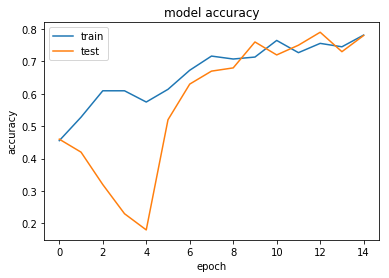

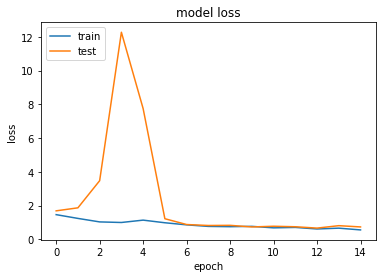

In [26]:
plot_loss_accuracy(history)

### TRANSFER LEARNING - MobileNet Conv2d + GRU

In [14]:
from keras.applications import mobilenet

def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    return model

#### Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes

In [12]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True)
print (model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 2s 0us/step
Number of layers in the pretrained mobilenet model:  87
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_____________________

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [14]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 220s 3s/step - loss: 1.2393 - categorical_accuracy: 0.4871 - val_loss: 0.8154 - val_categorical_accuracy: 0.6700

Epoch 00001: val_loss improved from inf to 0.81540, saving model to model_retrain_mobilenet_gru_2020-08-1701_39_21.017332/model-00001-1.24469-0.48869-0.81540-0.67000.h5
Epoch 2/20
67/67 [==============================] - 126s 2s/step - loss: 0.5727 - categorical_accuracy: 0.8070 - val_loss: 0.6965 - val_categorical_accuracy: 0.7900

Epoch 00002: val_loss improved from 0.81540 to 0.69651, saving model to model_retrain_mobilenet_gru_2020-08-1701_39_21.017332/model-00002-0.56962-0.80845-0.69651-0.79000.h5
Epoch 3/20
67/67 [==============================] - 125s 2s/step - loss: 0.3952 - categorical_accuracy: 0.8503 - val_loss: 0.3157 - val_categorical_accuracy: 0.8900

Epoch 00003: val_loss improved from 0.69651 to 0.31570, saving model to model_retrain_mobilenet_gru_2020-08-1701_39_21.017332/model-00003-0.39314-0.85219-0.31570-0.89000.h

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


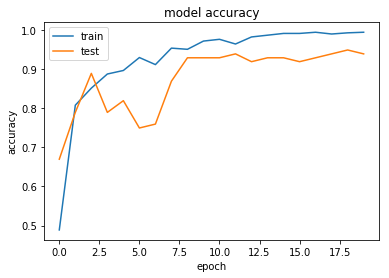

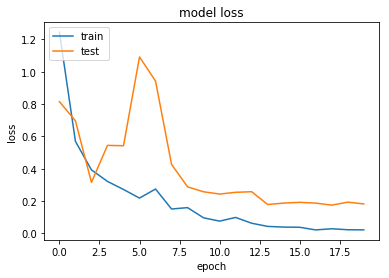

In [15]:
plot_loss_accuracy(history)

#### Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes + Random data transformations on training data set

In [16]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(gru=True, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


Number of layers in the pretrained mobilenet model:  87
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)     

In [17]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [18]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 304s 5s/step - loss: 1.1945 - categorical_accuracy: 0.5208 - val_loss: 0.8145 - val_categorical_accuracy: 0.6700

Epoch 00001: val_loss improved from inf to 0.81450, saving model to model_retrain_mobilenet_gru_2020-08-1701_39_21.017332/model-00001-1.20115-0.51584-0.81450-0.67000.h5
Epoch 2/20
67/67 [==============================] - 195s 3s/step - loss: 0.5592 - categorical_accuracy: 0.7791 - val_loss: 0.4608 - val_categorical_accuracy: 0.7600

Epoch 00002: val_loss improved from 0.81450 to 0.46079, saving model to model_retrain_mobilenet_gru_2020-08-1701_39_21.017332/model-00002-0.56348-0.77677-0.46079-0.76000.h5
Epoch 3/20
67/67 [==============================] - 222s 3s/step - loss: 0.3805 - categorical_accuracy: 0.8537 - val_loss: 0.6482 - val_categorical_accuracy: 0.7600

Epoch 00003: val_loss did not improve from 0.46079
Epoch 4/20
67/67 [==============================] - 212s 3s/step - loss: 0.3271 - categorical_accuracy: 0.8671 - val_los

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


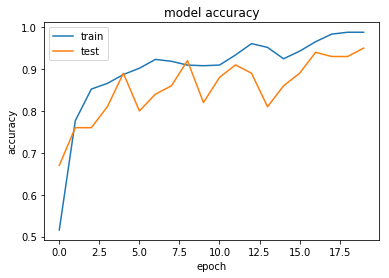

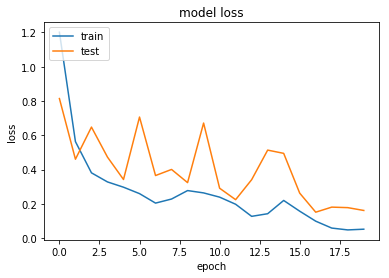

In [19]:
plot_loss_accuracy(history)

#### Mobilenet (fine tune) + GRU (128 cells) + 128 dense nodes

In [20]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=True, gru=True, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


Number of layers in the pretrained mobilenet model:  87
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_10 (TimeDis (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_11 (TimeDis (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 20, 1024)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)     

In [21]:
callbacks_list = model_callbacks("model_finetune_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [22]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 112s 2s/step - loss: 1.1282 - categorical_accuracy: 0.5443 - val_loss: 1.0780 - val_categorical_accuracy: 0.5800

Epoch 00001: val_loss improved from inf to 1.07798, saving model to model_finetune_mobilenet_gru_2020-08-1701_39_21.017332/model-00001-1.12791-0.54299-1.07798-0.58000.h5
Epoch 2/20
67/67 [==============================] - 105s 2s/step - loss: 0.5444 - categorical_accuracy: 0.7895 - val_loss: 0.9907 - val_categorical_accuracy: 0.6400

Epoch 00002: val_loss improved from 1.07798 to 0.99072, saving model to model_finetune_mobilenet_gru_2020-08-1701_39_21.017332/model-00002-0.54671-0.78733-0.99072-0.64000.h5
Epoch 3/20
67/67 [==============================] - 123s 2s/step - loss: 0.2745 - categorical_accuracy: 0.8980 - val_loss: 0.6902 - val_categorical_accuracy: 0.7600

Epoch 00003: val_loss improved from 0.99072 to 0.69022, saving model to model_finetune_mobilenet_gru_2020-08-1701_39_21.017332/model-00003-0.27260-0.90045-0.69022-0.7600

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


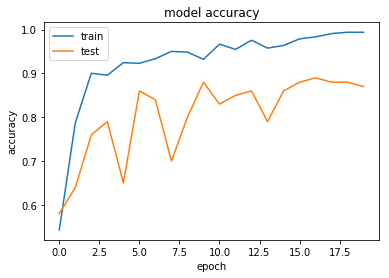

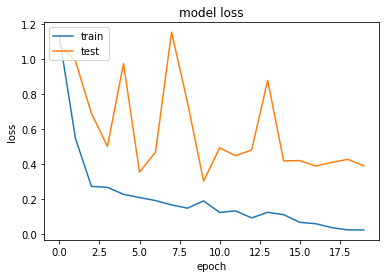

In [23]:
plot_loss_accuracy(history)

#### Mobilenet (re train all wieghts) + LSTM (128 cells) + 128 dense nodes




In [24]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=False, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


Number of layers in the pretrained mobilenet model:  87
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_14 (TimeDis (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 20, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)     

In [25]:
callbacks_list = model_callbacks("model_retrain_mobilenet_lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [26]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 124s 2s/step - loss: 1.1452 - categorical_accuracy: 0.5274 - val_loss: 0.7148 - val_categorical_accuracy: 0.7200

Epoch 00001: val_loss improved from inf to 0.71476, saving model to model_retrain_mobilenet_lstm_2020-08-1701_39_21.017332/model-00001-1.14445-0.52941-0.71476-0.72000.h5
Epoch 2/20
67/67 [==============================] - 113s 2s/step - loss: 0.6169 - categorical_accuracy: 0.7782 - val_loss: 0.4317 - val_categorical_accuracy: 0.8400

Epoch 00002: val_loss improved from 0.71476 to 0.43173, saving model to model_retrain_mobilenet_lstm_2020-08-1701_39_21.017332/model-00002-0.59909-0.78281-0.43173-0.84000.h5
Epoch 3/20
67/67 [==============================] - 122s 2s/step - loss: 0.6265 - categorical_accuracy: 0.7562 - val_loss: 0.9295 - val_categorical_accuracy: 0.7100

Epoch 00003: val_loss did not improve from 0.43173
Epoch 4/20
67/67 [==============================] - 127s 2s/step - loss: 0.5991 - categorical_accuracy: 0.7841 - val_l

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


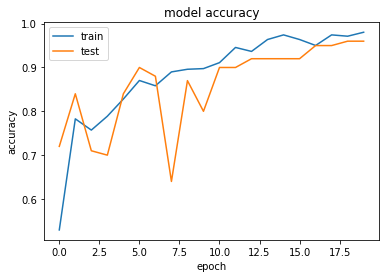

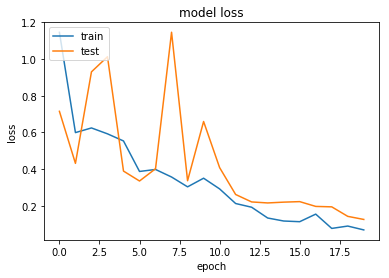

In [27]:
plot_loss_accuracy(history)

#### Mobilenet (re train all weights) + 64 dense nodes

In [28]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=True, num_images=num_frames, lstm_gru_cells=128, dense_nodes=64)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


Number of layers in the pretrained mobilenet model:  87
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_18 (TimeDis (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 20, 1024)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)     

In [29]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru_64")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [30]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 138s 2s/step - loss: 1.1623 - categorical_accuracy: 0.5274 - val_loss: 0.8992 - val_categorical_accuracy: 0.6600

Epoch 00001: val_loss improved from inf to 0.89919, saving model to model_retrain_mobilenet_gru_64_2020-08-1701_39_21.017332/model-00001-1.16454-0.52941-0.89919-0.66000.h5
Epoch 2/20
67/67 [==============================] - 111s 2s/step - loss: 0.6366 - categorical_accuracy: 0.7607 - val_loss: 0.6279 - val_categorical_accuracy: 0.7200

Epoch 00002: val_loss improved from 0.89919 to 0.62788, saving model to model_retrain_mobilenet_gru_64_2020-08-1701_39_21.017332/model-00002-0.62528-0.76169-0.62788-0.72000.h5
Epoch 3/20
67/67 [==============================] - 115s 2s/step - loss: 0.4228 - categorical_accuracy: 0.8488 - val_loss: 0.8110 - val_categorical_accuracy: 0.7200

Epoch 00003: val_loss did not improve from 0.62788
Epoch 4/20
67/67 [==============================] - 123s 2s/step - loss: 0.2954 - categorical_accuracy: 0.8995 - v

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


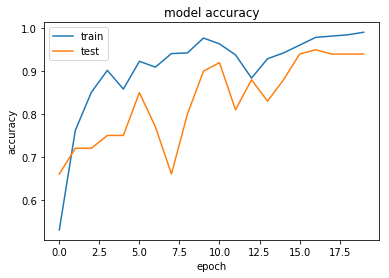

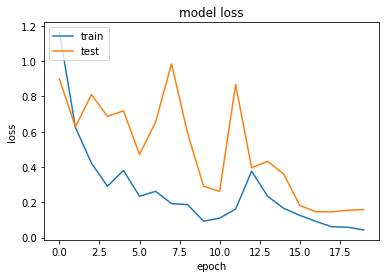

In [31]:
plot_loss_accuracy(history)

#### Mobilenet (re train all weights) + 64 dense nodes +  on training data set + Random data transformations

In [15]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=False, num_images=num_frames, lstm_gru_cells=128, dense_nodes=64)
print(model.summary())

# epochs = 25
# batch size = 10
# num frames per video = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 2s 0us/step
Number of layers in the pretrained mobilenet model:  87
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_____________________

In [16]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru_64")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [17]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 257s 4s/step - loss: 1.2670 - categorical_accuracy: 0.4796 - val_loss: 0.9601 - val_categorical_accuracy: 0.6400

Epoch 00001: val_loss improved from inf to 0.96006, saving model to model_retrain_mobilenet_gru_64_2020-08-1705_46_20.025955/model-00001-1.26310-0.48115-0.96006-0.64000.h5
Epoch 2/25
67/67 [==============================] - 139s 2s/step - loss: 0.8810 - categorical_accuracy: 0.6607 - val_loss: 1.2199 - val_categorical_accuracy: 0.4900

Epoch 00002: val_loss did not improve from 0.96006
Epoch 3/25
67/67 [==============================] - 144s 2s/step - loss: 0.7133 - categorical_accuracy: 0.7368 - val_loss: 0.8631 - val_categorical_accuracy: 0.6600

Epoch 00003: val_loss improved from 0.96006 to 0.86307, saving model to model_retrain_mobilenet_gru_64_2020-08-1705_46_20.025955/model-00003-0.71120-0.73756-0.86307-0.66000.h5
Epoch 4/25
67/67 [==============================] - 155s 2s/step - loss: 0.5714 - categorical_accuracy: 0.7980 - v

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


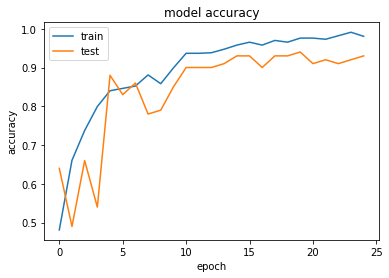

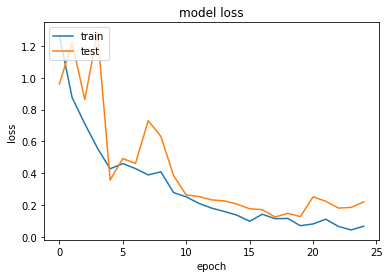

In [18]:
plot_loss_accuracy(history)